In [ ]:
# Date    :   2024-12-01
# Author  :   Dongwoo Yoon
# Contact :   dbsehddn0901@gmail.com


# 라이브러리 import

In [1]:
# 파일 및 데이터 조작 관련 라이브러리
import os
from glob import glob
from collections import Counter

# 데이터 분석 및 데이터프레임 조작
import pandas as pd
from sklearn.model_selection import train_test_split

# 딥러닝 및 PyTorch 관련 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR

# 데이터 시각화 및 이미지 처리
import matplotlib.pyplot as plt
from PIL import Image

# 기타 유틸리티
import random
import numpy as np
from tqdm import tqdm

# Colab 전용 파일 업로드 도구
from google.colab import files


# 데이터셋 로드

In [ ]:
!pip install kaggle

In [ ]:
# upload kaggle.json
files.upload()

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# download datasets
!kaggle datasets download -d jangedoo/utkface-new

In [ ]:
!unzip utkface-new.zip

In [7]:
folder_name = 'UTKFace'

file_mapping = {
    "UTKFace/61_1_20170109142408075.jpg.chip.jpg": "UTKFace/61_1_1_20170109142408075.jpg.chip.jpg",
    "UTKFace/39_1_20170116174525125.jpg.chip.jpg": "UTKFace/39_0_1_20170116174525125.jpg.chip.jpg",
    "UTKFace/61_1_20170109150557335.jpg.chip.jpg": "UTKFace/61_1_3_20170109150557335.jpg.chip.jpg"
}

def parse_dataset(dataset_path, ext='jpg'):
    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, _, _ = filename.split('_')

            '''
              손실 함수로 nn.CrossEntropyLoss() 사용

              nn.CrossEntropyLoss는 모델 출력(logits)과 정수형 레이블을 입력

              정수형 레이블은 0부터 시작하는 정수값.

              따라서 age 레이블을 다음과 같이 변경

              1         ->  0
              2         ->  1
              3         ->  2
                    .
                    .
                    .
              79        ->  78
              80 ~ 89   ->  79
              90 ~ 116  ->  80
            '''
            if int(age) // 10 == 8:
                age = 79
            elif int(age) // 10 >= 9:
                age = 80
            else:
                age = int(age) - 1

            return age, int(gender)
        except Exception as ex:
            return None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:

        if file in file_mapping:
            file = file_mapping[file]

        info = parse_info_from_file(file)
        if info[0] is not None:
            records.append(info)
        else:
          print(file)

    df = pd.DataFrame(records)

    df['file'] = files[:len(records)]
    df.columns = ['age', 'gender', 'file']
    df = df.dropna()

    return df

df = parse_dataset(folder_name)

print(df.head())

   age  gender                                           file
0   50       0  UTKFace/51_0_3_20170104220403390.jpg.chip.jpg
1   54       1  UTKFace/55_1_3_20170119200044963.jpg.chip.jpg
2   49       0  UTKFace/50_0_0_20170104021859988.jpg.chip.jpg
3   52       1  UTKFace/53_1_0_20170103183702714.jpg.chip.jpg
4    0       0   UTKFace/1_0_3_20161219225252688.jpg.chip.jpg


In [8]:
number_of_age_classes = len(df['age'].unique())
print(number_of_age_classes)

81


# GPU 환경

In [9]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

!nvidia-smi

True
1
Thu Dec  5 03:45:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------------

# 랜덤시드 고정

In [10]:
def seed_everything(seed):
    random.seed(seed)  # Python
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # PyTorch cuda
    torch.backends.cudnn.deterministic = True  # CuDNN
    torch.backends.cudnn.benchmark = False  # CuDNN benchmark

In [11]:
seed_everything(seed=32)

# Train / Valid / Test 데이터셋 분리

- UTKFace 데이터는 train, valid, test 데이터셋 구분이 없어 분리 필요

- Ratio
      train : valid : test = 7 : 2 : 1

In [12]:
# stratify는 **데이터를 분할(split)**할 때, 특정 컬럼이나 배열의 클래스 분포를 유지하도록 도와주는 역할을 합니다.
stratify_array = np.array(list(zip(df['age'], df['gender'])))

# df -> 70% train_df, 30% temp_df
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% temp_df
    random_state=0,
    shuffle=True,
    stratify=stratify_array,
)

temp_stratify_array = np.array(list(zip(temp_df['age'], temp_df['gender'])))

# temp_df -> valid_df, test_df (2:1)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,  # 1/3 test_df
    random_state=0,
    shuffle=True,
    stratify=temp_stratify_array,
)

# print result
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 16595
Validation set size: 4742
Test set size: 2371


# DataSet, DataLoader 생성


In [13]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender


In [14]:
# 이미지 전처리를 위한 변환 작업 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

batch_size = 128

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

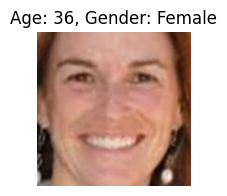

In [15]:
# Train dataset에서 첫 번째 샘플 가져오기
img, age, gender = train_dataset[0]

# 텐서를 이미지로 변환
img = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
img = (img * 255)

# 이미지 시각화
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.title(f"Age: {age}, Gender: {'Male' if gender == 0 else 'Female'}")
plt.axis('off')
plt.show()


# 전이 학습 (Transfer Learning)

## 1 . 모델


In [16]:
# 모델 클래스 정의
class AgeGenderModel(nn.Module):
    def __init__(self, base_model, num_age_classes):
        super(AgeGenderModel, self).__init__()

        # 사전 학습된 모델 로드
        self.base_model = base_model

        # 기존 fc의 출력을 기반으로 새로운 fc 계층을 추가
        num_features = self.base_model.fc.out_features  # 기존 fc 계층의 출력 차원

        # 기존 fc 계층은 그대로 두고, 새로운 fc 계층을 이어붙임
        self.fc = nn.Sequential(
            nn.Linear(num_features, 128),  # 기존 fc의 출력에 연결될 새로운 fc
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # 성별 출력 계층
        self.gender_logits = nn.Linear(128, 2)  # 성별 분류 (2개 클래스)

        # 나이 출력 계층
        self.age_logits = nn.Linear(128, num_age_classes)  # 나이 분류 (num_age_classes 개 클래스)

    def forward(self, x):
        # 기본 모델을 통해 특징 추출
        features = self.base_model(x)

        # 기존 fc 계층의 출력을 새로운 fc 계층에 통과시킴
        features = self.fc(features)

        # 성별과 나이 예측
        gender_logits = self.gender_logits(features)
        age_logits = self.age_logits(features)

        return gender_logits, age_logits



In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
base_model = models.resnet18(pretrained=True)  # ImageNet 데이터로 학습된 ResNet18 모델 로드

for param in base_model.parameters():
    param.requires_grad = True

# AgeGenderModel 정의
model = AgeGenderModel(base_model, number_of_age_classes)  # 사용자 정의 AgeGenderModel 생성

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 사용 가능 여부에 따라 디바이스 설정 (GPU 또는 CPU)

# 모델을 설정된 디바이스로 이동
model = model.to(device)  # 모델을 GPU 또는 CPU로 이동


## 2 . 손실 함수

In [18]:
# 교차 엔트로피 손실 함수 초기화
criterion_gender = nn.CrossEntropyLoss()  # 성별 출력에 대한 손실
criterion_age = nn.CrossEntropyLoss()     # 나이 출력에 대한 손실

# 총 손실 계산 함수
def calculate_total_loss(gender_preds, age_preds, gender_labels, age_labels, alpha=1.0, beta=1.0):
    loss_gender = criterion_gender(gender_preds, gender_labels)
    loss_age = criterion_age(age_preds, age_labels)
    total_loss = alpha * loss_gender + beta * loss_age
    return total_loss


## 3 . 옵티마이저

In [29]:
# 최적화 알고리즘으로 Adam 사용
# filter(lambda p: p.requires_grad, model.parameters())는 requires_grad=True로 설정된 파라미터만 옵티마이저에 전달
# - 사전 학습된 모델의 고정된 파라미터(requires_grad=False)를 제외하여 불필요한 계산 낭비 방지
# - lr: 학습률(learning rate), weight_decay: L2 정규화 항
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # 학습 가능한 파라미터만 전달
    lr=1e-3,  # 학습률 설정
    weight_decay=1e-5  # 가중치 감소(L2 정규화)로 과적합 방지
)

# StepLR 스케줄러 정의 (매 10 에폭마다 학습률을 0.1배씩 감소)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## 4 . 학습

In [21]:
# 학습 파라미터 설정
num_epochs = 50
best_val_acc = 0.0
patience = 5
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 훈련 및 검증 나이 Top-3 정확도 추적하기 위한 리스트
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct_gender = 0
    train_correct_age_top3 = 0
    train_total = 0

    for inputs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()

        # 모델의 출력
        gender_logits, age_logits = model(inputs)

        # 손실 계산
        total_loss = calculate_total_loss(gender_logits, age_logits, genders, ages)

        # 역전파
        total_loss.backward()
        optimizer.step()

        train_running_loss += total_loss.item()

        # 성별 정확도 계산
        _, predicted_gender = torch.max(gender_logits, 1)
        train_correct_gender += (predicted_gender == genders).sum().item()

        # 나이 예측에 대한 Top-3 정확도 계산
        _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
        train_correct_age_top3 += (predicted_age_top3 == ages.unsqueeze(1)).sum().item()  # predicted_age_top3는 [batch_size, 3] 형태이고, ages는 [batch_size]이므로 unsqueeze(1)

        train_total += ages.size(0)

    # 평균 손실 및 정확도 계산
    train_avg_loss = train_running_loss / len(train_loader)
    train_acc_gender = train_correct_gender / train_total
    train_acc_age_top3 = train_correct_age_top3 / train_total

    # 검증 단계
    model.eval()
    val_running_loss = 0.0
    val_correct_gender = 0
    val_correct_age_top3 = 0
    val_total = 0

    with torch.no_grad():
        for inputs, ages, genders in valid_loader:
            inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

            # 모델의 출력
            gender_logits, age_logits = model(inputs)

            # 총 손실 계산
            total_loss = calculate_total_loss(gender_logits, age_logits, genders, ages)

            val_running_loss += total_loss.item()

            # 성별 정확도 계산
            _, predicted_gender = torch.max(gender_logits, 1)
            val_correct_gender += (predicted_gender == genders).sum().item()

            # 나이 예측에 대한 Top-3 정확도 계산
            _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
            val_correct_age_top3 += (predicted_age_top3 == ages.unsqueeze(1)).sum().item()

            val_total += ages.size(0)

    # 평균 검증 손실 및 정확도 계산
    val_avg_loss = val_running_loss / len(valid_loader)
    val_acc_gender = val_correct_gender / val_total
    val_acc_age_top3 = val_correct_age_top3 / val_total

    # 손실 기록
    train_losses.append(train_avg_loss)
    valid_losses.append(val_avg_loss)

    # 나이 Top-3 정확도 기록
    train_accs.append(train_acc_age_top3)
    valid_accs.append(val_acc_age_top3)

    # 학습 및 검증 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {train_avg_loss:.4f}, Train Gender Acc: {train_acc_gender:.4f}, Train Age Top-3 Acc: {train_acc_age_top3:.4f}")
    print(f"  Val Loss: {val_avg_loss:.4f}, Val Gender Acc: {val_acc_gender:.4f}, Val Age Top-3 Acc: {val_acc_age_top3:.4f}")

    # 조기 종료를 위한 정확도 비교 (Age Top-3 기준)
    if val_acc_age_top3 > best_val_acc:
        best_val_acc = val_acc_age_top3
        no_improve = 0
        # 모델 저장
        torch.save(model.state_dict(), f"best_model.pth")
        print(f"Model saved at epoch {epoch+1}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

    # 스케줄러 step 호출 (매 에폭 끝에서 호출)
    scheduler.step()


Epoch 1/50: 100%|██████████| 130/130 [00:47<00:00,  2.74it/s]


Epoch [1/50]:
  Train Loss: 4.9619, Train Gender Acc: 0.6877, Train Age Top-3 Acc: 0.0983
  Val Loss: 4.5965, Val Gender Acc: 0.7946, Val Age Top-3 Acc: 0.1908
Model saved at epoch 1


Epoch 2/50: 100%|██████████| 130/130 [00:46<00:00,  2.77it/s]


Epoch [2/50]:
  Train Loss: 4.5506, Train Gender Acc: 0.8124, Train Age Top-3 Acc: 0.1788
  Val Loss: 4.2837, Val Gender Acc: 0.8507, Val Age Top-3 Acc: 0.2254
Model saved at epoch 2


Epoch 3/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [3/50]:
  Train Loss: 4.3297, Train Gender Acc: 0.8500, Train Age Top-3 Acc: 0.2151
  Val Loss: 4.1278, Val Gender Acc: 0.8718, Val Age Top-3 Acc: 0.2469
Model saved at epoch 3


Epoch 4/50: 100%|██████████| 130/130 [00:47<00:00,  2.73it/s]


Epoch [4/50]:
  Train Loss: 4.1826, Train Gender Acc: 0.8739, Train Age Top-3 Acc: 0.2305
  Val Loss: 4.0199, Val Gender Acc: 0.8821, Val Age Top-3 Acc: 0.2661
Model saved at epoch 4


Epoch 5/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [5/50]:
  Train Loss: 4.0591, Train Gender Acc: 0.8883, Train Age Top-3 Acc: 0.2551
  Val Loss: 3.9286, Val Gender Acc: 0.8906, Val Age Top-3 Acc: 0.2801
Model saved at epoch 5


Epoch 6/50: 100%|██████████| 130/130 [00:47<00:00,  2.73it/s]


Epoch [6/50]:
  Train Loss: 3.9557, Train Gender Acc: 0.9007, Train Age Top-3 Acc: 0.2713
  Val Loss: 3.8662, Val Gender Acc: 0.8918, Val Age Top-3 Acc: 0.2843
Model saved at epoch 6


Epoch 7/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [7/50]:
  Train Loss: 3.8556, Train Gender Acc: 0.9123, Train Age Top-3 Acc: 0.2838
  Val Loss: 3.8194, Val Gender Acc: 0.8939, Val Age Top-3 Acc: 0.2898
Model saved at epoch 7


Epoch 8/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [8/50]:
  Train Loss: 3.7708, Train Gender Acc: 0.9238, Train Age Top-3 Acc: 0.2954
  Val Loss: 3.7721, Val Gender Acc: 0.9007, Val Age Top-3 Acc: 0.2916
Model saved at epoch 8


Epoch 9/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [9/50]:
  Train Loss: 3.6814, Train Gender Acc: 0.9364, Train Age Top-3 Acc: 0.3107
  Val Loss: 3.7398, Val Gender Acc: 0.8981, Val Age Top-3 Acc: 0.2976
Model saved at epoch 9


Epoch 10/50: 100%|██████████| 130/130 [00:47<00:00,  2.73it/s]


Epoch [10/50]:
  Train Loss: 3.5944, Train Gender Acc: 0.9414, Train Age Top-3 Acc: 0.3220
  Val Loss: 3.7135, Val Gender Acc: 0.8971, Val Age Top-3 Acc: 0.2976


Epoch 11/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [11/50]:
  Train Loss: 3.5215, Train Gender Acc: 0.9531, Train Age Top-3 Acc: 0.3341
  Val Loss: 3.7106, Val Gender Acc: 0.8979, Val Age Top-3 Acc: 0.3007
Model saved at epoch 11


Epoch 12/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [12/50]:
  Train Loss: 3.5100, Train Gender Acc: 0.9522, Train Age Top-3 Acc: 0.3381
  Val Loss: 3.7060, Val Gender Acc: 0.8969, Val Age Top-3 Acc: 0.2995


Epoch 13/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [13/50]:
  Train Loss: 3.5043, Train Gender Acc: 0.9555, Train Age Top-3 Acc: 0.3365
  Val Loss: 3.7038, Val Gender Acc: 0.8971, Val Age Top-3 Acc: 0.2988


Epoch 14/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [14/50]:
  Train Loss: 3.4988, Train Gender Acc: 0.9563, Train Age Top-3 Acc: 0.3352
  Val Loss: 3.7030, Val Gender Acc: 0.8960, Val Age Top-3 Acc: 0.2992


Epoch 15/50: 100%|██████████| 130/130 [00:47<00:00,  2.73it/s]


Epoch [15/50]:
  Train Loss: 3.4744, Train Gender Acc: 0.9561, Train Age Top-3 Acc: 0.3421
  Val Loss: 3.7032, Val Gender Acc: 0.8971, Val Age Top-3 Acc: 0.3001


Epoch 16/50: 100%|██████████| 130/130 [00:47<00:00,  2.72it/s]


Epoch [16/50]:
  Train Loss: 3.4695, Train Gender Acc: 0.9573, Train Age Top-3 Acc: 0.3404
  Val Loss: 3.6985, Val Gender Acc: 0.8969, Val Age Top-3 Acc: 0.3005
Early stopping triggered.


## 5 . Loss, Top-3 Accuracy 시각화


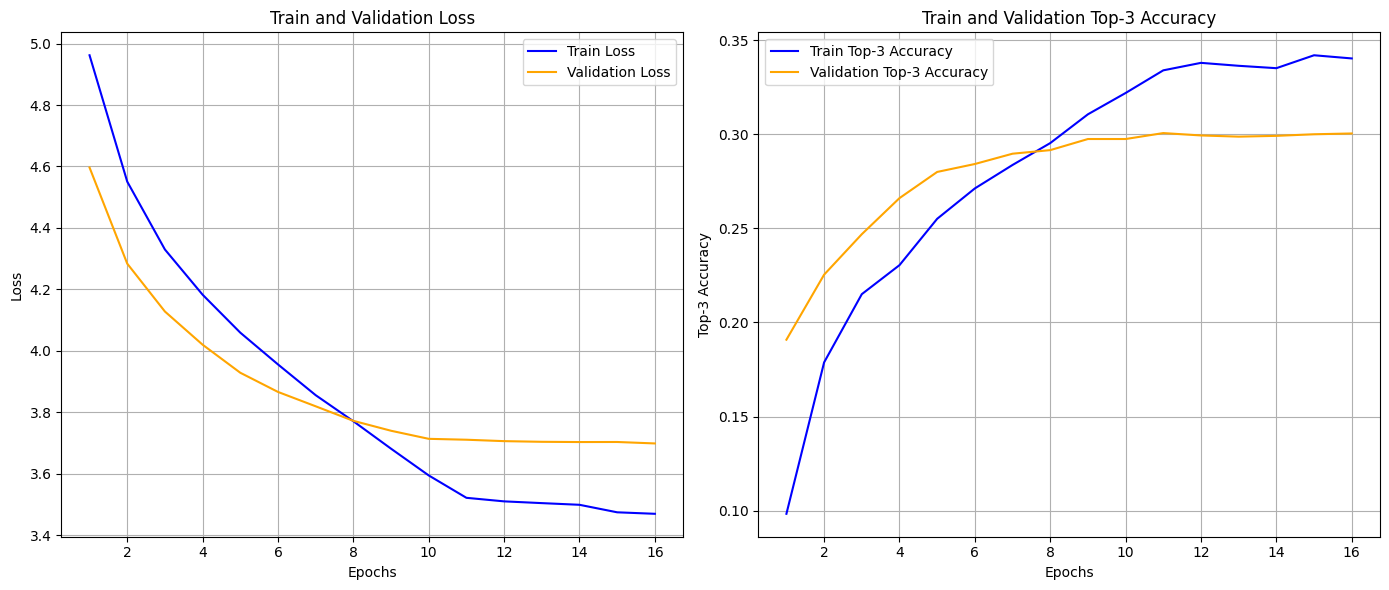

In [22]:
epochs = range(1, len(train_losses) + 1)

# 그래프 생성
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, valid_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Top-3 Accuracy", color="blue")
plt.plot(epochs, valid_accs, label="Validation Top-3 Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Top-3 Accuracy")
plt.title("Train and Validation Top-3 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 데이터 증강 (Data Augmentation)


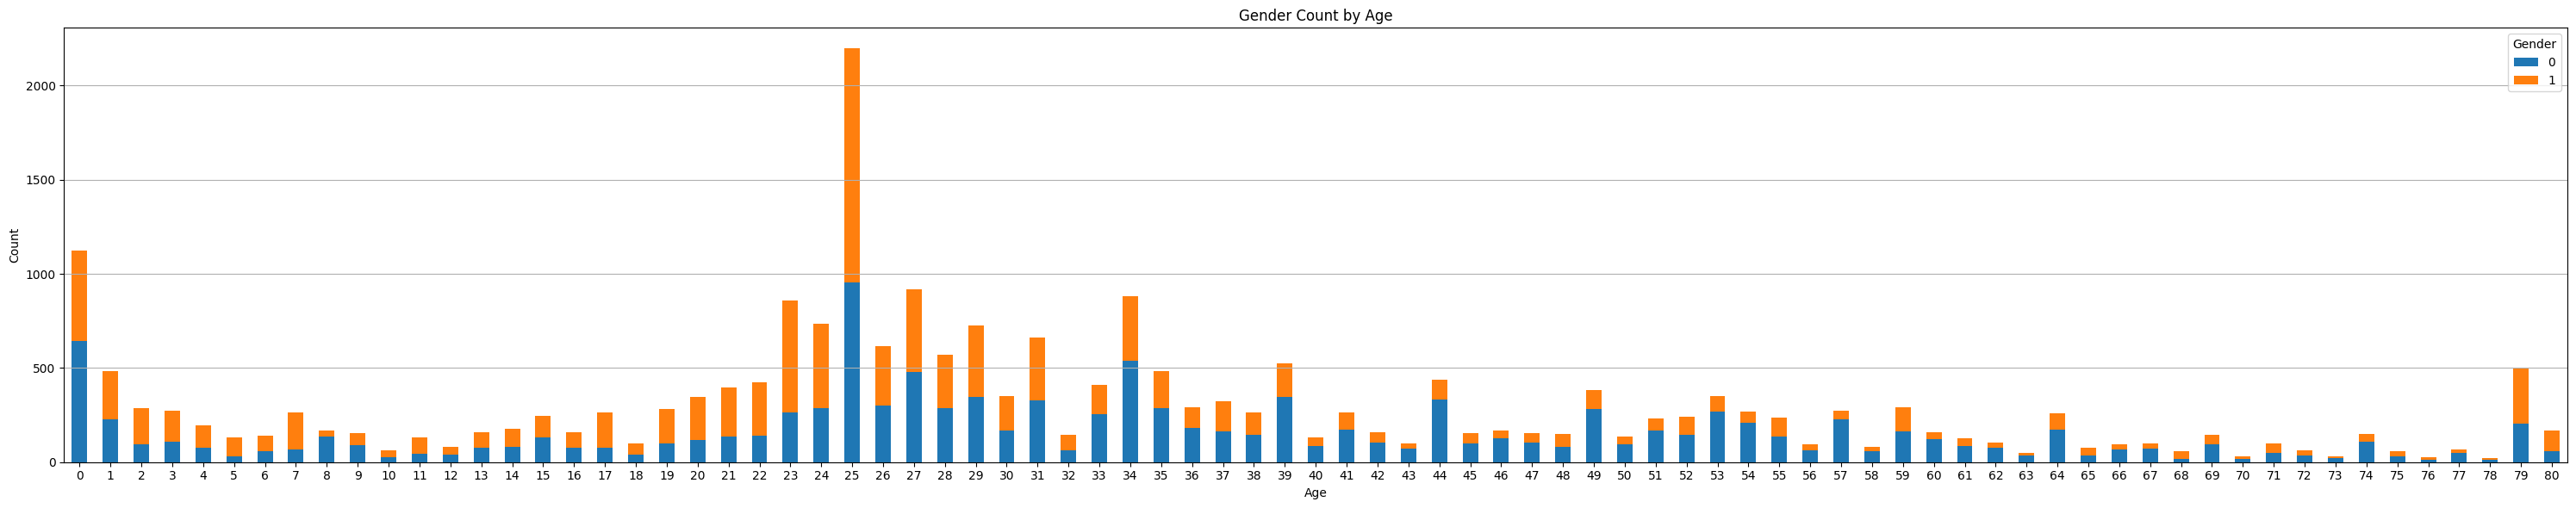

In [20]:
# Count the number of males and females by age
age_gender_counts = df.groupby(['age', 'gender']).size().unstack(fill_value=0)

# Plot the graph
age_gender_counts.plot(kind='bar', stacked=True, figsize=(30, 6))

# Set the title and labels
plt.title('Gender Count by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y')  # Add grid lines for better visualization

# Show the graph
plt.tight_layout()
plt.show()

## 1 . 오버 샘플링

In [21]:
# Count the number of entries for each age (combining genders)
age_counts = train_df.groupby("age").size().reset_index(name="Count")

# Display the result
print(age_counts)

# Count 값을 기준으로 데이터를 나눌 구간(bins)과 레이블(labels) 정의
bins = [0, 400, 600, 1300, float('inf')]
labels = ['0-400', '401-600', '601-1300', '1301+']  # 각 구간에 대한 레이블 설정

# Count 값에 따라 Group 열 추가
age_counts['Group'] = pd.cut(age_counts['Count'], bins=bins, labels=labels)

# Group 열을 기준으로 age 값을 리스트 형태로 그룹화
age_groups = age_counts.groupby('Group', observed=False)['age'].apply(list)

# 결과를 사전 형태로 변환하여 보기 쉽게 정리
age_group_dict = age_groups.to_dict()

# 보기 좋은 형식으로 결과를 출력하는 함수 정의
def pretty_print_age_groups(age_group_dict):
    for group, ages in age_group_dict.items():
        print(f"{group}:")
        print(", ".join(map(str, ages)))
        print()  # 각 그룹 사이에 빈 줄 추가

# 결과를 보기 좋게 출력
pretty_print_age_groups(age_group_dict)

    age  Count
0     0    786
1     1    338
2     2    202
3     3    191
4     4    138
..  ...    ...
76   76     20
77   77     49
78   78     16
79   79    353
80   80    118

[81 rows x 2 columns]
0-400:
1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 28, 30, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80

401-600:
24, 26, 29, 31

601-1300:
0, 23, 27, 34

1301+:
25



In [22]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class AugmentedDataset(Dataset):
    def __init__(self, dataframe, include_ages, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe[dataframe['age'].isin(include_ages)]
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender

# 이미지 전처리를 위한 변환 작업 정의
transform1 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

transform2 = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

transform3 = transforms.Compose([
    transforms.RandomCrop((180, 180)), # 랜덤으로 180x180 크기로 크롭
    transforms.Resize((200, 200)),  # 이미지를 200x200으로 크기 조정
    transforms.ColorJitter(brightness=0.3, contrast=0.3),  # 밝기와 대비 조정
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

transform4 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 밝기와 대비 조정
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

ages_400 = age_group_dict['0-400']
ages_600 = age_group_dict['401-600']
ages_1300 = age_group_dict['601-1300']

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

batch_size = 128

augmented_train_dataset1 = AugmentedDataset(train_df, ages_400 + ages_600 + ages_1300, transform=transform1)
augmented_train_dataset2 = AugmentedDataset(train_df, ages_400 + ages_600, transform=transform2)
augmented_train_dataset3 = AugmentedDataset(train_df, ages_400, transform=transform3)
augmented_train_dataset4 = AugmentedDataset(train_df, ages_400, transform=transform4)
combined_train_dataset = ConcatDataset([train_dataset, augmented_train_dataset1, augmented_train_dataset2, augmented_train_dataset3, augmented_train_dataset4])

# 데이터 로더 설정
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)



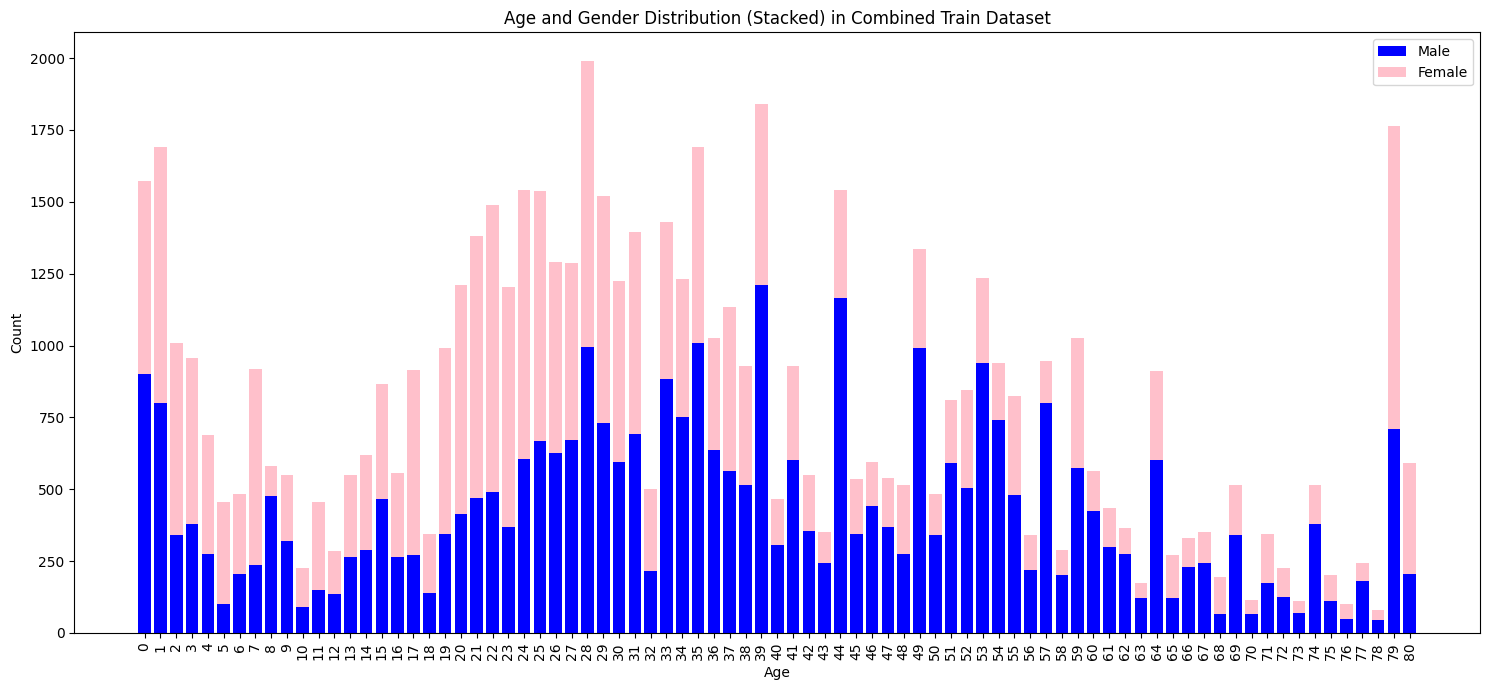

In [23]:
def plot_age_gender_stacked(dataset, title):
    """
    주어진 데이터셋에서 나이에 따른 성별 분포를 스택형 막대 그래프로 시각화합니다.

    Args:
    - dataset: PyTorch Dataset 또는 ConcatDataset
    - title: 그래프 제목
    """
    # 모든 샘플에서 (age, gender) 데이터를 추출
    age_gender = []
    for _, age, gender in dataset:
        age_gender.append((age, gender))

    # 나이별로 남성과 여성의 수를 집계
    age_gender_counter = Counter(age_gender)
    age_labels = sorted(set(age for age, _ in age_gender))
    male_counts = [age_gender_counter[(age, 0)] for age in age_labels]  # 성별 0 (남성)
    female_counts = [age_gender_counter[(age, 1)] for age in age_labels]  # 성별 1 (여성)

    # 그래프 생성
    x = np.arange(len(age_labels))

    plt.figure(figsize=(15, 7))
    plt.bar(x, male_counts, label='Male', color='blue')  # 남성
    plt.bar(x, female_counts, bottom=male_counts, label='Female', color='pink')  # 여성 (남성 위에 쌓음)

    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(x, age_labels, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 학습 데이터셋 분포 (스택형 그래프)
plot_age_gender_stacked(combined_train_dataset, "Age and Gender Distribution (Stacked) in Combined Train Dataset")

## 2 . 학습

In [ ]:
# 학습 파라미터 설정
num_epochs = 50
best_val_acc = 0.0
patience = 5
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 훈련 및 검증 나이 Top-3 정확도 추적하기 위한 리스트
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct_gender = 0
    train_correct_age_top3 = 0
    train_total = 0

    for inputs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()

        # 모델의 출력
        gender_logits, age_logits = model(inputs)

        # 손실 계산
        total_loss = calculate_total_loss(gender_logits, age_logits, genders, ages, 0.1, 1)

        # 역전파
        total_loss.backward()
        optimizer.step()

        train_running_loss += total_loss.item()

        # 성별 정확도 계산
        _, predicted_gender = torch.max(gender_logits, 1)
        train_correct_gender += (predicted_gender == genders).sum().item()

        # 나이 예측에 대한 Top-3 정확도 계산
        _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
        train_correct_age_top3 += (predicted_age_top3 == ages.unsqueeze(1)).sum().item()  # predicted_age_top3는 [batch_size, 3] 형태이고, ages는 [batch_size]이므로 unsqueeze(1)

        train_total += ages.size(0)

    # 평균 손실 및 정확도 계산
    train_avg_loss = train_running_loss / len(train_loader)
    train_acc_gender = train_correct_gender / train_total
    train_acc_age_top3 = train_correct_age_top3 / train_total

    # 검증 단계
    model.eval()
    val_running_loss = 0.0
    val_correct_gender = 0
    val_correct_age_top3 = 0
    val_total = 0

    with torch.no_grad():
        for inputs, ages, genders in valid_loader:
            inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

            # 모델의 출력
            gender_logits, age_logits = model(inputs)

            # 총 손실 계산
            total_loss = calculate_total_loss(gender_logits, age_logits, genders, ages, 0.1, 1)

            val_running_loss += total_loss.item()

            # 성별 정확도 계산
            _, predicted_gender = torch.max(gender_logits, 1)
            val_correct_gender += (predicted_gender == genders).sum().item()

            # 나이 예측에 대한 Top-3 정확도 계산
            _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
            val_correct_age_top3 += (predicted_age_top3 == ages.unsqueeze(1)).sum().item()

            val_total += ages.size(0)

    # 평균 검증 손실 및 정확도 계산
    val_avg_loss = val_running_loss / len(valid_loader)
    val_acc_gender = val_correct_gender / val_total
    val_acc_age_top3 = val_correct_age_top3 / val_total

    # 손실 기록
    train_losses.append(train_avg_loss)
    valid_losses.append(val_avg_loss)

    # 나이 Top-3 정확도 기록
    train_accs.append(train_acc_age_top3)
    valid_accs.append(val_acc_age_top3)

    # 학습 및 검증 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {train_avg_loss:.4f}, Train Gender Acc: {train_acc_gender:.4f}, Train Age Top-3 Acc: {train_acc_age_top3:.4f}")
    print(f"  Val Loss: {val_avg_loss:.4f}, Val Gender Acc: {val_acc_gender:.4f}, Val Age Top-3 Acc: {val_acc_age_top3:.4f}")

    # 조기 종료를 위한 정확도 비교 (Age Top-3 기준)
    if val_acc_age_top3 > best_val_acc:
        best_val_acc = val_acc_age_top3
        no_improve = 0
        # 모델 저장
        torch.save(model.state_dict(), f"best_model.pth")
        print(f"Model saved at epoch {epoch+1}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

    # 스케줄러 step 호출 (매 에폭 끝에서 호출)
    # scheduler.step()


Epoch 1/50: 100%|██████████| 509/509 [03:09<00:00,  2.68it/s]


Epoch [1/50]:
  Train Loss: 3.4801, Train Gender Acc: 0.6956, Train Age Top-3 Acc: 0.2522
  Val Loss: 3.7831, Val Gender Acc: 0.6693, Val Age Top-3 Acc: 0.2345
Model saved at epoch 1


Epoch 2/50: 100%|██████████| 509/509 [03:09<00:00,  2.69it/s]


Epoch [2/50]:
  Train Loss: 3.1361, Train Gender Acc: 0.7890, Train Age Top-3 Acc: 0.3174
  Val Loss: 3.2871, Val Gender Acc: 0.8505, Val Age Top-3 Acc: 0.2973
Model saved at epoch 2


Epoch 3/50:  25%|██▌       | 128/509 [00:47<02:21,  2.69it/s]

## 3 . Loss, Top-3 Accuracy 시각화

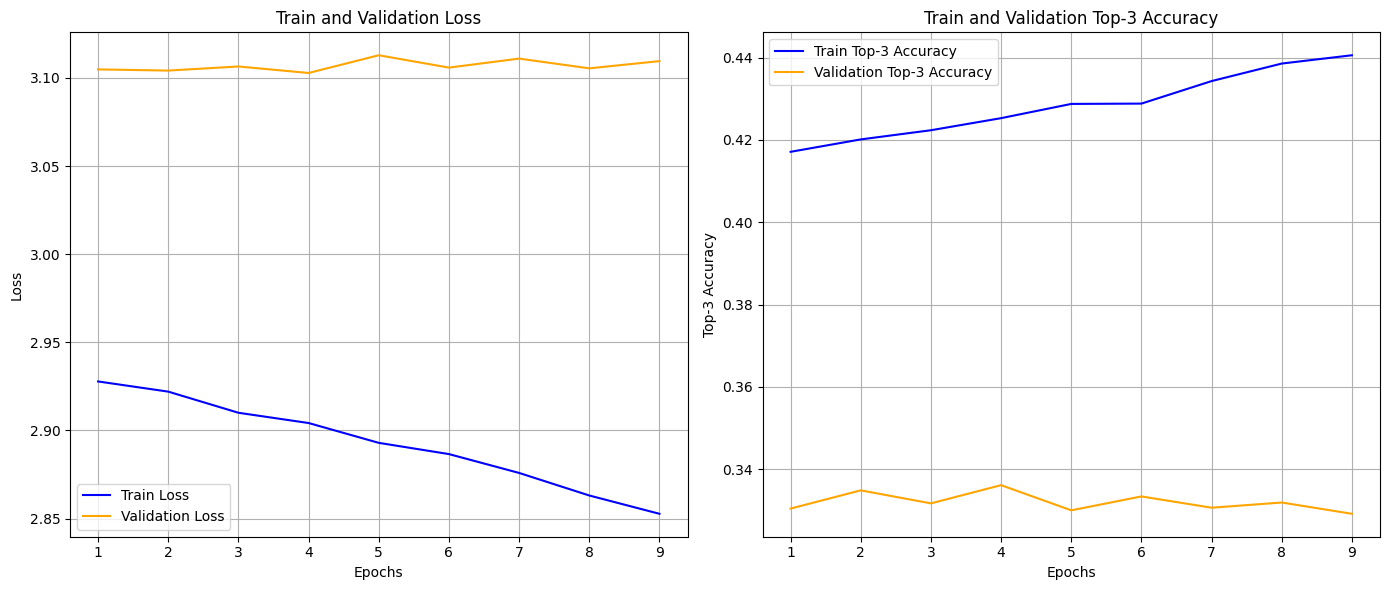

In [28]:
epochs = range(1, len(train_losses) + 1)

# 그래프 생성
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, valid_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Top-3 Accuracy", color="blue")
plt.plot(epochs, valid_accs, label="Validation Top-3 Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Top-3 Accuracy")
plt.title("Train and Validation Top-3 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Best Model

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model = model.to('cuda')